# Clouds classification from unstructured MPAS

Optimized by gemini.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

Spin up a dask cluster.

In [2]:
# from ncar_jobqueue import NCARCluster
# cluster = PBSCluster()
# cluster.scale(4 * 9) # Ask for 4 x 9 workers
# cluster

from dask_jobqueue import PBSCluster
# Create a PBS cluster object
# cluster = PBSCluster(
#     job_name = 'dask-wk23-hpc',
#     cores = 1,
#     processes = 1,
#     log_directory = '/glade/derecho/scratch/rberrios/dask/',
#     local_directory = '/glade/derecho/scratch/rberrios/dask/',
#     resource_spec = 'select=1:ncpus=1:mem=10GB',
#     queue = 'casper',
#     walltime = '12:00:00',
#     interface = 'mgt'
# )
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    processes = 1,
    memory = '10GiB',
    account = 'UOKL0049',
    log_directory = '/glade/derecho/scratch/ruppert/dask/',
    local_directory = '/glade/derecho/scratch/ruppert/dask/',
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    # queue = 'main',
    walltime = '12:00:00',
    interface = 'ext'
)
print(cluster.job_script())

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


#!/usr/bin/env bash

#PBS -N dask-wk23-hpc
#PBS -q casper
#PBS -A UOKL0049
#PBS -l select=1:ncpus=1:mem=10GB
#PBS -l walltime=12:00:00
#PBS -e /glade/derecho/scratch/rberrios/dask//
#PBS -o /glade/derecho/scratch/rberrios/dask//

/glade/u/apps/opt/conda/envs/npl-2024b/bin/python -m distributed.cli.dask_worker tcp://10.18.206.72:45183 --name dummy-name --nthreads 1 --memory-limit 101.51GiB --nanny --death-timeout 60 --local-directory /glade/derecho/scratch/rberrios/dask/ --interface mgt



/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37861 instead
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account y

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMemDos/proxy/37861/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMemDos/proxy/37861/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.72:45183,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMemDos/proxy/37861/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# Scale the cluster to n workers (which will use n jobs here)
cluster.scale(36)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(36)

Define path to data, labels, colors, etc.

In [5]:
dx = "TC_3km"
grid_path = "/glade/work/rberrios/MPAS/grid_files/x5.tropical_3km_10N.grid.nc"
expLabels = {
    'CTL': 'CTL',
    'plus4K' : 'plus4K',
    'minus4K':'minus4K',
    'HOMO_RAD':'HOMO RAD',
}

lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',\
    'plus4K':'red',\
    'HOMO_RAD':'purple',\
}

Read initial conditions and find tropical indexes

In [6]:
grid = xr.open_dataset(grid_path)
latCell = np.degrees(grid.latCell)
lonCell = np.degrees(grid.lonCell)

#find indexes within desired latitudinal range
ind_within_lat = np.where( (latCell >= 15) & (latCell <= 20.0) )[0]

Define function to classify the clouds.

In [7]:
# 
# Column-based precipitation classification algorithm designed for application on
# numerical model output.
# 
# It has been designed using WRF model output using the Thompson and Eidhammer
# (2014, JAS) microphysics scheme, which has 2 liquid and 3 frozen categories as
# listed and expected below.
# 
# Input:
# 
#       Q_INT: n-D array of vertically integrated hydrometeors as f(q, X), where
#               q(5) is the hydrometeor dimension, arranged as
#               ['QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP'] and X includes the
#               remaining (time and) spatial dimensions.
# Returns:
# 
#       C_TYPE: (n-2)-D array as f(X) with classification results:
#               0: non-cloud
#           Convective:
#               1: deep convective
#               2: congestus
#               3: shallow
#           Layered:
#               4: stratiform
#               5: anvil (weaker rainfall)
# 
# Emily Luschen - emily.w.luschen-1@ou.edu
# James Ruppert - jruppert@ou.edu
# 5/19/23
# Rosi RB - modified to ingest water paths and to return dask arrays

def precip_class(q_int):
    shape = q_int.shape
    ndims=len(shape)
    shape_out = shape[1:ndims]

    # Integrated water variables
    # Ensure these are Dask arrays if q_int is a Dask array
    LWP = q_int[0]
    IWP = q_int[1]
    # For Q_INT input, q_int[2] is QICE, q_int[3] is QSNOW, q_int[4] is QGRAUP
    # Your original code used q_int[2] for rain, q_int[3] for graupel.
    # Make sure this indexing is consistent with your actual 'q_int' structure.
    # Based on the function docstring: ['QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP']
    # And your q_int = np.array([ds.lwp, ds.iwp, ds.rwp, ds.gwp]), this means:
    # q_int[0] = lwp (QCLOUD + QRAIN combined in your data?)
    # q_int[1] = iwp (QICE + QSNOW + QGRAUP combined in your data?)
    # q_int[2] = rwp (QRAIN from your data)
    # q_int[3] = gwp (QGRAUP from your data)
    # So, the original function's `q_int[2]` (for rain_thresh) is `rwp` (your q_int[2])
    # and `q_int[3]` (for graup_thresh) is `gwp` (your q_int[3]).
    # This seems consistent, just making sure the comments are aligned.

    RWP = q_int[2] # Rain Water Path
    GWP = q_int[3] # Graupel Water Path

    TWP = LWP + IWP

    # Use xarray.where for masking with Dask arrays
    # Ensure LWP is not zero before division to avoid inf/nan
    cr = xr.where(LWP != 0, IWP / LWP, np.inf) # Use np.inf for where LWP is zero, so cr_thresh condition handles it

    # Threshold parameters (unchanged)
    twp_thresh = 1e-1
    cr_thresh = 2
    graup_thresh = 1e-4
    rain_thresh_conv = 1e-1
    rain_thresh_strat = 1e-2

    # Initialize output array as a Dask array of zeros
    # Use dask.array.zeros or xarray.zeros_like to create a Dask-backed array
    # The shape should be (Time, nCells) after the initial q_int[0] selection
    # Assuming q_int has dimensions (variable, Time, nCells)
    c_type_shape = LWP.shape # Should be (Time, nCells)
    c_type = da.zeros(c_type_shape, dtype=np.int8)

    # Use dask.array.where for efficient boolean indexing with Dask arrays
    # Deep convection
    condition_dc = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP >= rain_thresh_conv) & \
                    (GWP >= graup_thresh))
    c_type = da.where(condition_dc, 1, c_type)

    # Congestus
    condition_cg = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP >= rain_thresh_conv) & \
                    (GWP < graup_thresh))
    c_type = da.where(condition_cg, 2, c_type)

    # Shallow
    condition_sc = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr <= cr_thresh) & \
                    (RWP < rain_thresh_conv))
    c_type = da.where(condition_sc, 3, c_type)

    # Stratiform
    condition_st = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr > cr_thresh) & \
                    (RWP >= rain_thresh_strat))
    c_type = da.where(condition_st, 4, c_type)

    # Anvil
    condition_an = ((LWP != 0) & (TWP > twp_thresh) & \
                    (cr > cr_thresh) & \
                    (RWP < rain_thresh_strat))
    c_type = da.where(condition_an, 5, c_type)

    return c_type # This will return a Dask array

Main loop to call the classification.

In [8]:
%%time
# Main loop
print('Starting classification loop...')
nCells_chunk_size = 100000
clouds = {}
for expName in ["minus4K","CTL","plus4K"]:
    data_path = f"/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/{expName}/TC_3km/"

    # Open the dataset with dask backend. This loads lazily.
    # Specify chunks to optimize memory usage and parallel processing.
    # You'll need to know typical chunk sizes for your variables, or let xarray guess.
    # For large datasets, manual chunking can be critical.
    # Example: If 'Time' dimension is large, chunk it. 'nCells' might be good to chunk too.
    # ds = xr.open_mfdataset(data_path + "waterPaths*", combine="nested", concat_dim="Time",
    #                        chunks={'Time': 'auto', 'nCells': 'auto'}) # 'auto' lets Dask guess
    # Or specify explicitly, e.g., {'Time': 24, 'nCells': 1000}
    print('opening')
    ds = xr.open_mfdataset(data_path + "waterPaths.2000-*", 
                           combine="nested", concat_dim="Time", 
                           parallel=True, chunks={"Time": -1, "nCells": nCells_chunk_size})

    print('subsetting')
    # Select cells within latitude range. This operation is also lazy if `ds` is Dask-backed.
    ds_tropical = ds.isel(nCells=ind_within_lat)

    print('reading variables')
    # Convert to a list of DataArrays, and wrap in dask.array.stack to create a single Dask array
    # This creates a Dask-backed array 'q_int_dask' without loading data into memory yet.
    q_int_dask = da.stack([
        ds_tropical.lwp.data,
        ds_tropical.iwp.data,
        ds_tropical.rwp.data,
        ds_tropical.gwp.data
    ], axis=0) # Stack along a new 0th dimension for the different water paths

    print('classifying')
    # Call the classification function. This will return a Dask array (c_type_dask).
    # The actual computation of c_type is still lazy at this point.
    c_type_dask = precip_class(q_int_dask)

    # Perform counts using Dask's capabilities.
    # Use .sum() on boolean arrays to count occurrences.
    # Use .compute() only *after* all sums are defined, to minimize data transfer.
    # This will trigger the Dask graph execution.
    # We collect all computations in a dictionary first.
    print('counting')
    cloud_computations = {
        'DC': (c_type_dask == 1).sum(),
        'CG': (c_type_dask == 2).sum(),
        'SC': (c_type_dask == 3).sum(),
        'ST': (c_type_dask == 4).sum(),
        'AN': (c_type_dask == 5).sum(),
    }

    print('dask.compute')
    # Now, use dask.compute to run all these sums in parallel
    # This is the point where the data will actually be loaded and processed by Dask workers.
    # This avoids loading the full `c_type` array into memory at once.
    results = dask.compute(cloud_computations)[0] # dask.compute returns a tuple of results

    cloudsThisExp = {
        'DC': results['DC'].item(), # .item() converts 0-d array to scalar
        'CG': results['CG'].item(),
        'SC': results['SC'].item(),
        'ST': results['ST'].item(),
        'AN': results['AN'].item(),
    }
    clouds[expName] = cloudsThisExp
    print(f"Finished processing {expName}")

print('Classification complete.')

Starting classification loop...
opening
subsetting
reading variables
classifying
counting
dask.compute


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 493.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Finished processing minus4K
opening
subsetting
reading variables
classifying
counting
dask.compute


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 493.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Finished processing CTL
opening
subsetting
reading variables
classifying
counting
dask.compute


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 493.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Finished processing plus4K
Classification complete.
CPU times: user 2h 2min 21s, sys: 2min 32s, total: 2h 4min 53s
Wall time: 2h 21min 24s


Plot the results.

36691899
37988384
32422178


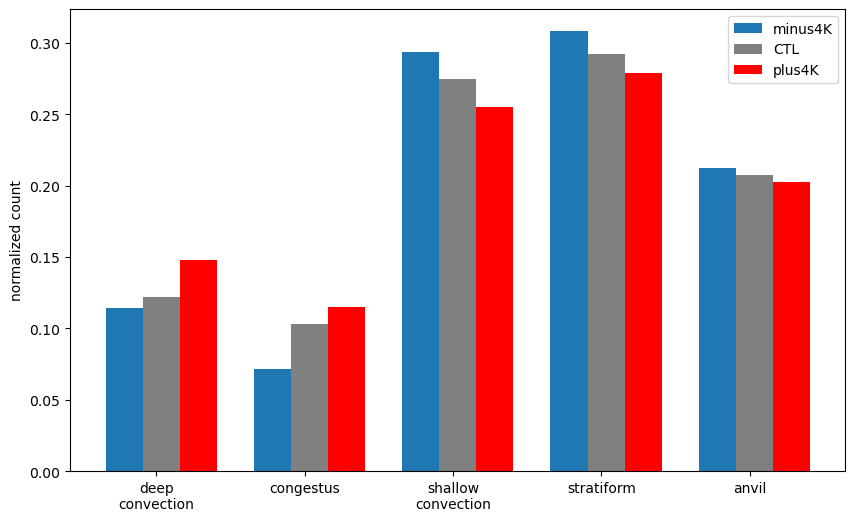

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

bin_width = 1.0
width = bin_width/4 # the width of the bars

num_variables = len(clouds['CTL']) # Number of variables
variables = list(clouds['CTL'].keys()) # Get variable names

variable_labels = ['deep\nconvection','congestus','shallow\nconvection','stratiform','anvil']

fig, ax = plt.subplots(figsize=(10,6))  # Adjust figure size as needed

bin_ctr = np.arange(num_variables)  # Use the number of variables for x-positions
multiplier = 0.125

for expName, measurement in clouds.items():
    offset = width * multiplier
    values = np.array([clouds[expName][var] for var in measurement])
    print(values.sum())
    values = values / values.sum()  # Normalize if needed
    rects = ax.bar(bin_ctr[0:] + offset, values[0:], width, label=expName, color=lineColors[expName])
    multiplier += 1

# Set the x-axis ticks and labels
ax.set_xticks(bin_ctr[0:] + width * (len(clouds) - 1) / 2)  # Center the ticks
ax.set_xticklabels(variable_labels[0:],fontsize=10) # Use variables as labels

ax.set_ylabel("normalized count") # Adjust label as needed
ax.legend()
plt.savefig('histogram_cloud_types_ASD_15-20N.jpeg',
            bbox_inches='tight',dpi=600)

In [10]:
cluster.close()

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
